# Notebook to evaluate experimental results

To re-run, go to supplementary code and run all cells below.

## Pre-training

### Resunet k=1

Setup

In [12]:
"""
Setup
Load mean, pre-processing function, import stuff
"""
from coco.architectures.depth import DepthPredictionScaffolder, ResidualDepth
from coco.transformations import zoom_rotate, random_rgb, random_crop, normalize_images, downsample, clip, noise, exp, flip_x

global mean
mean = np.load("/data/data/nyu_v2.npy")
def preprocess(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]
    global mean

    size = (228, 304)
    images, labels = normalize_images(images, labels, mean, std=71.571201304890508)
    images, labels = random_crop(images, labels, size, deterministic=True)
    images, labels = downsample(images, labels, (1, 2))

    return images, labels

In [13]:
"""
Load network and its weights
"""
scaffolder = DepthPredictionScaffolder(ResidualDepth, inference=True, k=1)

scaffolder.compile()
scaffolder.load("/data/data/resunet_thesis.npz")

INFO:coco.nn:Number of parameters for output 'None': 46054721
INFO:coco.nn:Compiling inference function.
INFO:coco.nn:Loading parameters from file '/data/data/resunet_thesis.npz'


In [31]:
"""
Iterate through the test data and calculate metrics
"""
db = "/data/data/test_v2.hdf5"
f = h5py.File(db)

images = np.array(f["images"])
depths = np.array(f["depths"])

cropped_depths = []
predictions = []

for index in range(images.shape[0]):
    images = images[index][np.newaxis]
    depths = depths[index][np.newaxis]
    # Pre process
    images, depths = preprocess(images, depths)
    # Infer
    pred = scaffolder.infer(images)[0]
    
    # Post process
    pred = post_process_depth(pred)
    
    cropped_depths.append(depths)
    predictions.append(pred)
    
    break
    
gt = np.concatenate(cropped_depths).squeeze()
predictions = np.concatenate(predictions).squeeze()

In [95]:
calculate_depth_metrics(predictions, gt)

RMSE  0.32206


Plot

Train


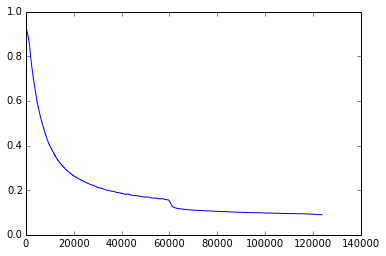

val


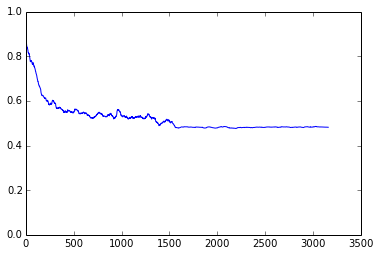

In [37]:
current_job = Job.from_name("nyu_depth_thesis")
current_job.load()
data = current_job.data

kernel_size = 1.

n_epochs = 80
if "train_losses" in data:    
    print "train"
    train_losses = np.array(data["train_losses"]).squeeze()
    kernel_size = len(train_losses) / 80
    plt.plot(np.convolve(train_losses, np.ones((kernel_size)), mode='valid') / kernel_size)
    plt.ylim(0.0, 1.0)
    plt.show()

if "val_losses" in data:
    print "val"
    val_losses = np.array(data["val_losses"]).squeeze()
    kernel_size = len(val_losses) / 80
    plt.plot(np.convolve(val_losses[:], np.ones((kernel_size)), mode='valid') /  kernel_size)
    plt.ylim(0.0, 1.0)
    plt.show()
    


### k = 0.5

In [39]:
"""
Load network and its weights
"""
scaffolder = DepthPredictionScaffolder(ResidualDepth, inference=True, k=0.5)

scaffolder.compile()
scaffolder.load("/data/data/resunet_half_thesis.npz")

INFO:coco.nn:Number of parameters for output 'None': 11541505
INFO:coco.nn:Compiling inference function.
INFO:coco.nn:Loading parameters from file '/data/data/resunet_half_thesis.npz'


In [47]:
"""
Iterate through the test data and calculate metrics
"""
db = "/data/data/test_v2.hdf5"
f = h5py.File(db)

images = np.array(f["images"])
depths = np.array(f["depths"])

cropped_depths = []
predictions = []

for index in range(images.shape[0]):
    images = images[index][np.newaxis]
    depths = depths[index][np.newaxis]
    # Pre process
    images, depths = preprocess(images, depths)
    # Infer
    pred = scaffolder.infer(images)[0]
    
    # Post process
    pred = post_process_depth(pred)
    
    cropped_depths.append(depths)
    predictions.append(pred)
    
    break

gt = np.concatenate(cropped_depths).squeeze()
predictions = np.concatenate(predictions).squeeze()
assert gt.shape == predictions.shape

In [96]:
calculate_depth_metrics(predictions, gt)

RMSE  0.32206


#### Plot 

train


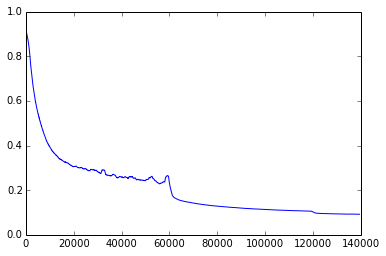

val


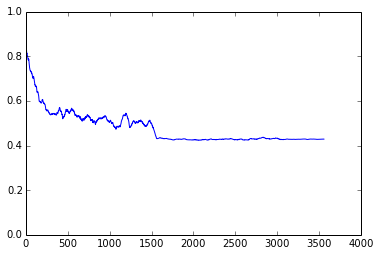

In [120]:
current_job = Job.from_name("nyu_depth_half_thesis")
current_job.load()
data = current_job.data

kernel_size = 1.

n_epochs = 90
if "train_losses" in data:    
    print "train"
    train_losses = np.array(data["train_losses"]).squeeze()
    kernel_size = len(train_losses) / n_epochs
    plt.plot(np.convolve(train_losses, np.ones((kernel_size)), mode='valid') / kernel_size)
    plt.ylim(0.0, 1.0)
    plt.show()

if "val_losses" in data:
    print "val"
    val_losses = np.array(data["val_losses"]).squeeze()
    kernel_size = len(val_losses) / n_epochs
    plt.plot(np.convolve(val_losses[:], np.ones((kernel_size)), mode='valid') /  kernel_size)
    plt.ylim(0.0, 1.0)
    plt.show()
    

## Fine-tuning

In [124]:
folds = [
    ("/data/data/resunet_f3d_half_limited_f1_thesis.npz", '/ssd/food3d/f3d-rgbd-val.hdf5'),
    ("/data/data/resunet_f3d_half_limited_f2_thesis.npz", '/ssd/food3d/f3d-rgbd-f2-val.hdf5')
]

Processing fold: /ssd/food3d/f3d-rgbd-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 11541505
INFO:coco.nn:Compiling inference function.
INFO:coco.nn:Loading parameters from file '/data/data/resunet_f3d_half_limited_f1_thesis.npz'


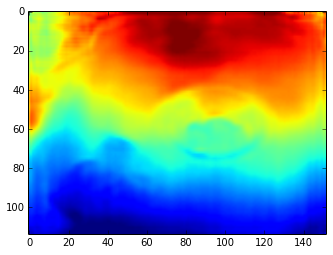

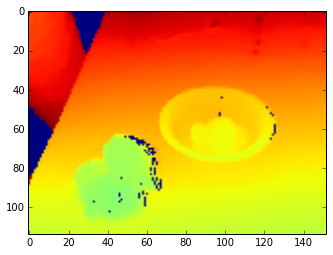

Processing fold: /ssd/food3d/f3d-rgbd-f2-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 11541505
INFO:coco.nn:Compiling inference function.
INFO:coco.nn:Loading parameters from file '/data/data/resunet_f3d_half_limited_f2_thesis.npz'


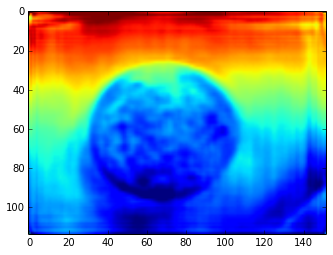

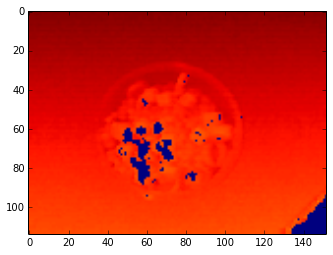

In [126]:
"""
Load network and its weights
"""
global mean
mean = np.load("/ssd/food3d/f3d-train.npy")
def preprocess(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)
    
    # Extract data from combined blob
    images = images[:,0:3,:,:]
    labels = labels[:,3,:,:]

    assert images.shape[0] == labels.shape[0]
    global mean

    size = (228, 304)
    images, labels = normalize_images(images, labels, mean, std=71.571201304890508)
    images, labels = random_crop(images, labels, size, deterministic=True)
    images, labels = downsample(images, labels, (1, 2))
    
    # Ommit large values TODO Yes?
    labels[labels > 1.2] = 0.

    return images, labels

"""
Do the prediction for each fold
"""
cropped_depths = []
predictions = []

for model, db  in folds:
    print "Processing fold: %s" % db
    f = h5py.File(db)
    scaffolder = DepthPredictionScaffolder(ResidualDepth, inference=True, k=0.5)
    scaffolder.compile()
    scaffolder.load(model)
    
    # Splitting is done by pre-processor
    images_loaded = np.array(f["rgbd"])
    depths_loaded = np.array(f["rgbd"])


    for index in range(images_loaded.shape[0]):
        if index!=5:
            continue
        images = images_loaded[index][np.newaxis]
        depths = depths_loaded[index][np.newaxis]
        
        # Pre process
        images, depths = preprocess(images, depths)
        # Infer
        pred = scaffolder.infer(images)[0]

        # Post process
        pred = post_process_depth(pred)
        
        plt.imshow(pred.squeeze())
        plt.show()
        
        plt.imshow(depths.squeeze())
        plt.show()
        
        cropped_depths.append(depths)
        predictions.append(pred)

        

gt = np.concatenate(cropped_depths).squeeze()
predictions = np.concatenate(predictions).squeeze()
assert gt.shape == predictions.shape

In [94]:
calculate_depth_metrics(predictions, gt)

RMSE  0.32206


train


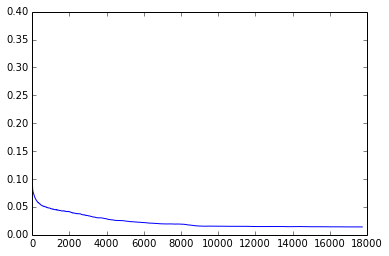

val


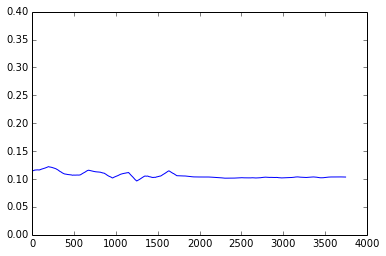

In [119]:
current_job = Job.from_name("f3d_depth_half_limited_f1_thesis")
current_job.load()
data = current_job.data

kernel_size = 1.

n_epochs = 40
if "train_losses" in data:    
    print "train"
    train_losses = np.array(data["train_losses"]).squeeze()
    kernel_size = len(train_losses) / n_epochs
    plt.plot(np.convolve(train_losses, np.ones((kernel_size)), mode='valid') / kernel_size)
    plt.ylim(0.0, .4)
    plt.show()

if "val_losses" in data:
    print "val"
    val_losses = np.array(data["val_losses"]).squeeze()
    kernel_size = len(val_losses) / n_epochs
    plt.plot(np.convolve(val_losses[:], np.ones((kernel_size)), mode='valid') /  kernel_size)
    plt.ylim(0.0, .4)
    plt.show()

## BU Regression

### BU Regression with GT Depth data

In [67]:
"""
Setup
Preprocessor, mean etc.
"""
from coco.architectures.regression import BURegressionScaffolder, BURegressor

global mean
mean = np.load("/ssd/food3d/f3d-rgbd-train.npy")

def preprocess(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]
    
    size = (228, 304)
    
    global mean

    images, _ = normalize_images(images, labels, mean)
    images, _ = random_crop(images, None, size, deterministic=True)

    return images, labels

In [79]:
folds = [
    ("/data/data/bu_regressor_rgbd_f3_thesis.npz", "/ssd/food3d/f3d-rgbd-f3-val.hdf5"),
    ("/data/data/bu_regressor_rgbd_f2_thesis.npz", "/ssd/food3d/f3d-rgbd-f2-val.hdf5"),
    ("/data/data/bu_regressor_rgbd_thesis.npz", "/ssd/food3d/f3d-rgbd-val.hdf5"),
]

In [80]:
original_bus = []
predictions = []

for model, db in folds:
    print "Pricessing fold: %s" % db
    scaffolder = BURegressionScaffolder(BURegressor, 
                                           inference=True,
                                           with_depth=True)
    scaffolder.load(model)
    scaffolder.compile()
    
    # Splitting is done by pre-processor
    images = np.array(f["rgbd"])
    bus = np.array(f["bus"])
    
    for index in range(images.shape[0]):
        images = images[index][np.newaxis]
        bus = bus[index][np.newaxis]
        
        # Pre process
        images, bus = preprocess(images, bus)
        # Infer
        pred = scaffolder.infer(images)[0]

        original_bus.append(bus)
        predictions.append(pred)

        break
gt = np.concatenate(original_bus).squeeze()
predictions = np.concatenate(predictions).squeeze()

assert gt.shape == predictions.shape

INFO:coco.nn:Number of parameters for output 'None': 23513217
INFO:coco.nn:Loading parameters from file '/data/data/bu_regressor_rgbd_f3_thesis.npz'
INFO:coco.nn:Compiling inference function.
INFO:coco.nn:Number of parameters for output 'None': 23513217
INFO:coco.nn:Loading parameters from file '/data/data/bu_regressor_rgbd_f2_thesis.npz'
INFO:coco.nn:Compiling inference function.
INFO:coco.nn:Number of parameters for output 'None': 23513217
INFO:coco.nn:Loading parameters from file '/data/data/bu_regressor_rgbd_thesis.npz'
INFO:coco.nn:Compiling inference function.


In [91]:
calculate_bu_metrics(predictions, gt)

RMSE  0.32206


### BU Regression with inferred depth

# Supplementary code, run this first

In [15]:
"""
Get coco lib in here
"""
import sys
import os
import inspect
import h5py
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)



In [3]:
from coco.job import Job
Job.set_job_dir("/data/coco-jobs-relocated")

In [6]:
"""
Matplotlib and stuff
"""
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

In [88]:
def rmse(prediction, gt):
    d = gt - prediction
    rmse = np.sqrt((d**2).mean())
    return rmse

In [89]:
def post_process_depth(depth):
    upper = np.percentile(depth, 99)
    lower = np.percentile(depth, 1)
    depth = depth.clip(lower, upper)
    return depth

In [93]:
def calculate_depth_metrics(pred, gt):
    r = rmse(pred, gt)
    print "RMSE ", r
    
    
    
def calculate_bu_metrics(pred, gt):
    r = rmse(pred, gt)
    print "RMSE ", r